# Figure S15. Ground truth recovery analysis

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import os
import glob
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import stats

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 192})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data of the ground truth (synthetic) simulation:

In [3]:
orig_data = np.load('./ground_truth/synthetic/it1.npz', allow_pickle=True)
orig_I_E = orig_data['sim_states'].flatten()[0]['I_E'].squeeze()

Load data of the recovery CMAES runs:

In [4]:
recov_opt = {}
recov_I_E = {}
best_opt_seeds = {}
sim_seeds = [410] + list(range(1, 50))

for sim_seed in sim_seeds:
    recov_opt[sim_seed] = {}
    recov_I_E[sim_seed] = {}   
    missing = False
    for opt_seed in [1, 2]:
        # load optimum gof
        try:
            recov_opt[sim_seed][opt_seed] = pd.read_csv(f'./ground_truth/recovery/sim-{sim_seed}_opt-{opt_seed}/cmaes_run-0/opt.csv', index_col=0).iloc[:, 0]
        except FileNotFoundError:
            print("sim_seed", sim_seed, "opt_seed", opt_seed, "not found")
            missing = True
            continue
        recov_opt[sim_seed][opt_seed]['opt_seed'] = opt_seed
        # load optimum simulation data
        sim_data = np.load(
            glob.glob(f'./ground_truth/recovery/sim-{sim_seed}_opt-{opt_seed}/cmaes_run-0/opt_sim/it*.npz')[0], 
            allow_pickle=True
        )
        recov_I_E[sim_seed][opt_seed] = sim_data['sim_states'].flatten()[0]['I_E'].flatten()
    if missing:
        continue
    best_opt_seed = int(pd.DataFrame(recov_opt[sim_seed]).T.set_index('opt_seed')['+gof'].idxmax())
    best_opt_seeds[sim_seed] = best_opt_seed

In [5]:
res = pd.DataFrame(index=best_opt_seeds.keys(), 
                   columns=[
                       '+gof', '+fc_corr', '-fcd_ks', '-fc_diff',
                       'I_E_r', 'I_E_madicc'
                   ], dtype=float
)

for sim_seed in best_opt_seeds.keys():
    best_opt_seed = best_opt_seeds[sim_seed]
    for measure in ['+gof', '+fc_corr', '-fcd_ks', '-fc_diff']:
        res.loc[sim_seed, measure] = recov_opt[sim_seed][best_opt_seed][measure]
    res.loc[sim_seed, 'I_E_r'] = scipy.stats.pearsonr(recov_I_E[sim_seed][best_opt_seed], orig_I_E).statistic
    res.loc[sim_seed, 'I_E_madicc'] = stats.madicc(recov_I_E[sim_seed][best_opt_seed], orig_I_E)

In [6]:
res

,+gof,+fc_corr,-fcd_ks,-fc_diff,I_E_r,I_E_madicc
410,0.965756,0.992406,-0.019231,-0.007419,0.977156,0.942805
1,0.821029,0.852763,-0.026442,-0.005292,0.808671,0.394861
2,0.802649,0.845533,-0.042308,-0.000576,0.617213,0.049545
3,0.834127,0.861217,-0.021154,-0.005936,0.829959,0.362633
4,0.793542,0.823693,-0.028846,-0.001305,0.606384,0.473569
5,0.817687,0.843608,-0.014904,-0.011017,0.814970,0.487239
6,0.803774,0.832722,-0.025000,-0.003948,0.483108,0.429917
7,0.788966,0.820988,-0.030769,-0.001253,0.856163,0.617455
8,0.824735,0.856627,-0.030288,-0.001604,0.759309,0.170088
9,0.811661,0.853632,-0.032212,-0.009760,0.772512,0.272116


In [7]:
res.iloc[1:].describe().round(3)

,+gof,+fc_corr,-fcd_ks,-fc_diff,I_E_r,I_E_madicc
count,49.000,49.000,49.000,49.000,49.000,49.000
mean,0.811,0.840,-0.027,-0.002,0.672,0.339
std,0.018,0.014,0.010,0.004,0.132,0.150
min,0.765,0.806,-0.065,-0.020,0.232,0.047
25%,0.801,0.832,-0.032,-0.002,0.603,0.257
50%,0.812,0.840,-0.027,-0.001,0.664,0.363
75%,0.823,0.853,-0.020,-0.000,0.766,0.451
max,0.844,0.863,-0.013,-0.000,0.915,0.617


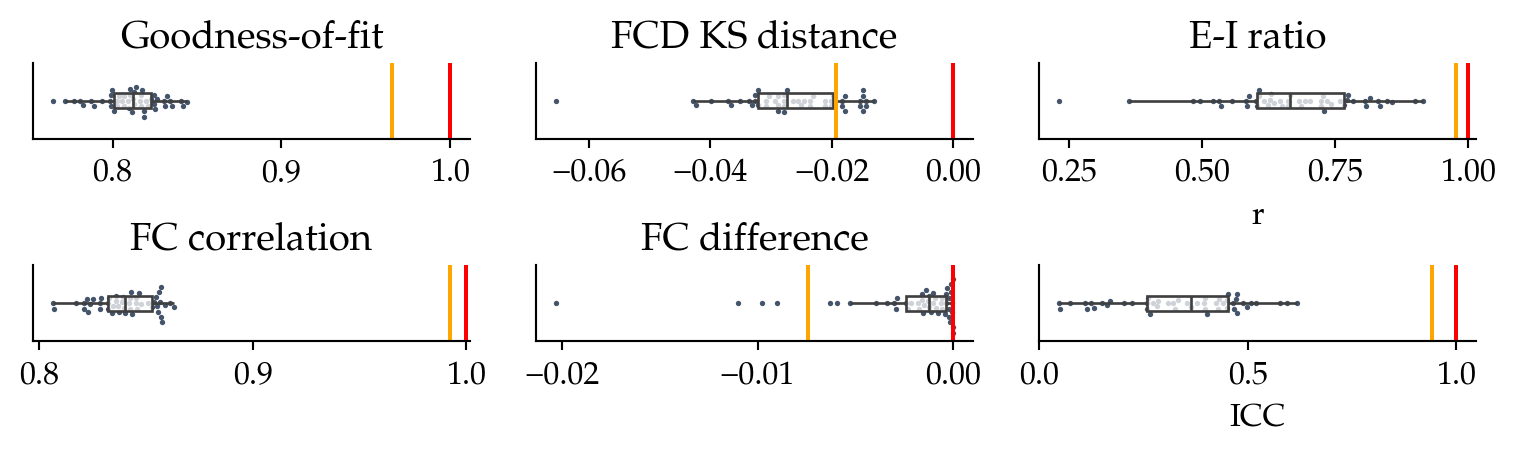

In [8]:
def box_swarm_plot(res, measure, target, ax):
    sns.swarmplot(
        x=res.iloc[1:].loc[:, measure],
        s=2, color='#44546A',
        ax=ax
    )
    sns.boxplot(
        x=res.iloc[1:].loc[:, measure],
        showfliers=False,
        showcaps=False, width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax)
    # add line of same-seed recovery run
    ax.axvline(x=res.iloc[0].loc[measure], color='orange')
    # add line of target
    ax.axvline(x=target, color='red')
    ax.set_yticks([])
    ax.set_xlabel('')
    sns.despine()
    plt.setp(ax.collections, zorder=0, label="")


fig, axes = plt.subplots(2, 3, figsize=(8, 2.5))
axes = axes.flatten(order='F')

titles = {
    '+gof': 'Goodness-of-fit',
    '+fc_corr': 'FC correlation',
    '-fc_diff': 'FC difference',
    '-fcd_ks': 'FCD KS distance',
    'I_E_r': 'E-I ratio',
}
labels = {
    'I_E_r': 'r',
    'I_E_madicc': 'ICC'
}
targets = {
    '+gof': 1.0,
    '+fc_corr': 1.0,
    '-fc_diff': 0.0,
    '-fcd_ks': 0.0,
    'I_E_r': 1.0,
    'I_E_madicc': 1.0
}

for i, measure in enumerate(['+gof', '+fc_corr', '-fcd_ks', '-fc_diff', 'I_E_r', 'I_E_madicc']):
    box_swarm_plot(res, measure, targets.get(measure, 1.0), axes[i])
    axes[i].set_title(titles.get(measure, ''))
    axes[i].set_xlabel(labels.get(measure, ''))

fig.tight_layout(pad=1.0)

Legend:

(0.0, 1.0, 0.0, 1.0)

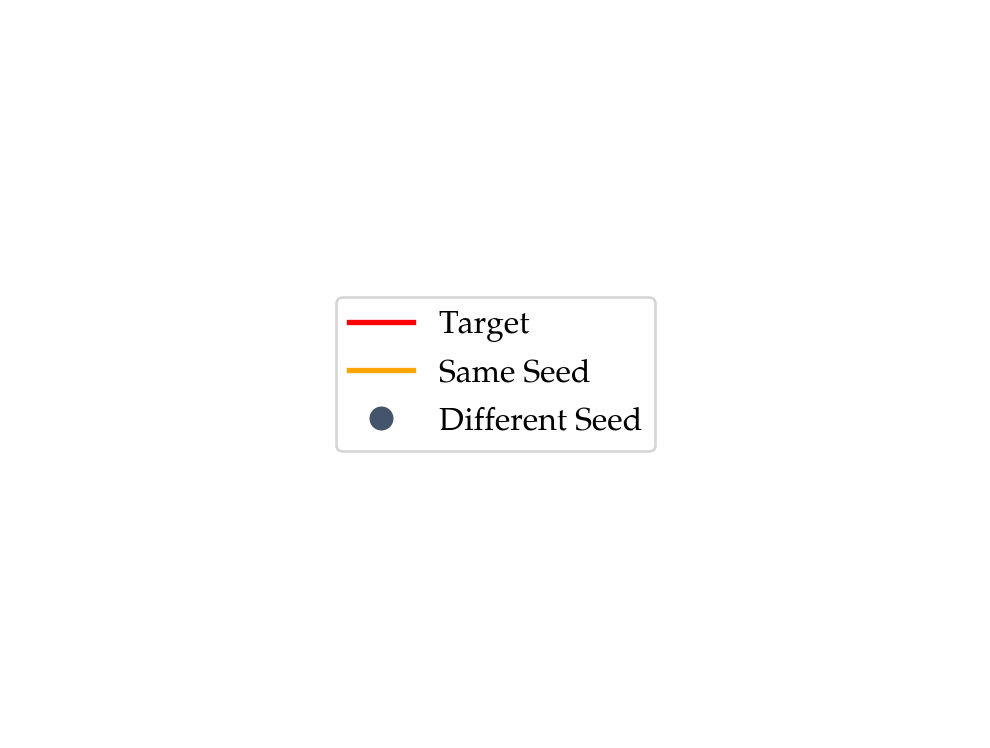

In [9]:
fig, ax = plt.subplots()
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='Target'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Same Seed'),
    plt.Line2D([0], [0], marker='o', color='#44546A', linestyle='None', markersize=8, label='Different Seed')
]
ax.legend(handles=legend_elements, loc='center')
ax.axis('off')